In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("https://raw.githubusercontent.com/mirea-aie-2025/aie-course-meta/main/seminars/S02/S02-hw-dataset.csv")
data.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [3]:
data.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


# Проверка качества данных

Пропуски

In [4]:
data.isnull().sum()

user_id      0
age          2
country      0
purchases    0
revenue      0
dtype: int64

In [5]:
data[data["age"].isnull()] # Два пропуска в age

,user_id,age,country,purchases,revenue
4,5,NaN,DE,6,1296
12,13,NaN,US,9,630


Дубликаты

In [6]:
data[data.duplicated(keep=False)] # Один дубль

,user_id,age,country,purchases,revenue
9,10,24.0,RU,7,511
40,10,24.0,RU,7,511


Удалим их

In [7]:
len(data) # Число записей с повторами и пропусками

41

In [8]:
clean_data = data.dropna().drop_duplicates()
len(clean_data) # Число записей без повторов и пропусков

38

Поиск подозрительных случаев

In [9]:
id = clean_data['user_id']
id.min() # Отрицательных id нет

1

In [10]:
len(id.unique()) # повторов id нет

38

In [11]:
country = clean_data['country'] # Нет стран, которых бы не существовало, в количестве тоже ничего подозрительного
country.value_counts()

country
FR    12
RU    12
US     7
DE     5
CN     2
Name: count, dtype: int64

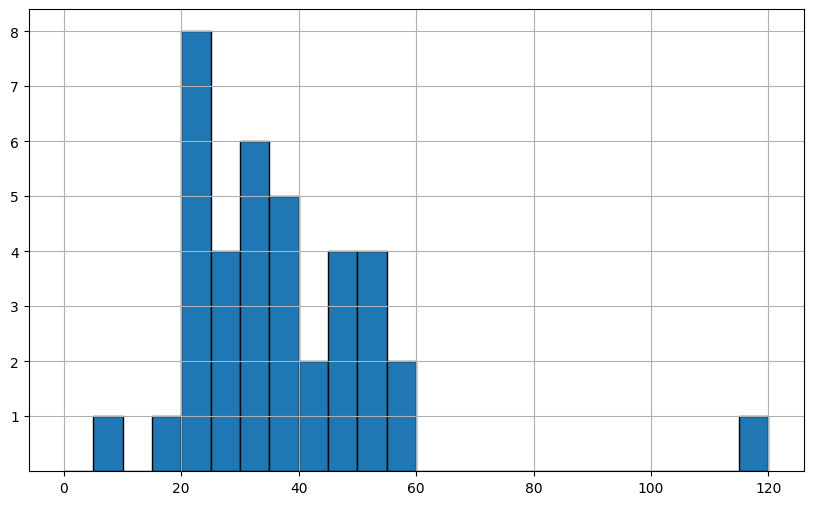

In [12]:
age = clean_data['age']
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(1, 15))
plt.grid()
plt.hist(age, edgecolor='black', bins=np.arange(0, max(age) + 5, 5))
plt.show() # Подозрительные возрасте - один человек аномально старый, а другой - странно молодой для получения дохода

In [13]:
clean_data[(clean_data['age'] > 100) | (clean_data['age'] < 20)] # id 6 и 21 подозрительные по описанным выше причинам. Также у id 6 -1 покупка

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
20,21,5.0,RU,8,1488
36,37,18.0,DE,4,1104


In [14]:
clean_data = clean_data[(clean_data['user_id'] != 6) & (clean_data['user_id'] != 21)] # удаляем подозрительные случаи

In [15]:
clean_data.shape

(36, 5)

In [16]:
clean_data['purchases'].describe() # Наименьшее значение - 0, наибольшее - 11

count    36.000000
mean      4.694444
std       2.539060
min       0.000000
25%       3.000000
50%       5.000000
75%       6.250000
max      11.000000
Name: purchases, dtype: float64

In [17]:
clean_data['revenue'].describe() # Наименьшее значение - 0, наибольшее - 2475

count      36.000000
mean      803.111111
std       637.430726
min         0.000000
25%       402.750000
50%       673.500000
75%      1106.750000
max      2475.000000
Name: revenue, dtype: float64

In [18]:
clean_data[clean_data['revenue']==0] # Доход может быть нулевым, но тогда число покупок также должно быть нулевым. В свою очередь, нулевое число покупок вовсе не значит, что доход также должен быть нулевым. Здесь наблюдаем 4 покупки при нулевом доходе

,user_id,age,country,purchases,revenue
6,7,46.0,RU,0,0
10,11,24.0,US,4,0
17,18,24.0,RU,0,0
33,34,28.0,FR,0,0


In [19]:
clean_data = clean_data[clean_data['user_id'] != 11] # Удаляем подозрительный случай

Устранённые проблемы качества данных:
1. Аномально большой и аномально малый возраст людей.
2. Наличие отрицательного числа покупок.
3. Нулевой доход при ненулевом количестве покупок.

# EDA

In [20]:
# Раннее мы посчитали частоты стран, но это было до очистки данных от аномалий, так что повторим
clean_data['country'].value_counts()

country
FR    11
RU    11
US     6
DE     5
CN     2
Name: count, dtype: int64

In [21]:
# Рассчитаем среднее число покупок по странам
clean_data.groupby('country').agg({
    'purchases': 'mean'
}
)

,purchases
country,
CN,4.500000
DE,6.600000
FR,4.727273
RU,4.272727
US,4.000000


In [22]:
# Разобьём группы по возрастам на пять групп по квантилям
clean_data['age_group'] = pd.qcut(clean_data['age'], q=5, precision=0)
clean_data

,user_id,age,country,purchases,revenue,age_group
0,1,25.0,FR,7,749,"(24.0, 32.0]"
1,2,24.0,RU,5,1115,"(17.0, 24.0]"
2,3,52.0,FR,7,399,"(47.0, 57.0]"
3,4,31.0,RU,6,654,"(24.0, 32.0]"
6,7,46.0,RU,0,0,"(37.0, 47.0]"
7,8,28.0,CN,2,456,"(24.0, 32.0]"
8,9,39.0,US,4,980,"(37.0, 47.0]"
9,10,24.0,RU,7,511,"(17.0, 24.0]"
11,12,20.0,CN,7,1652,"(17.0, 24.0]"
13,14,36.0,DE,9,2358,"(32.0, 37.0]"


In [23]:
# Рассчитаем медиану и среднее возраста и дохода пользователей в разных возрастных группах, а также самую частую страну в каждом интервале
clean_data.groupby('age_group').agg({
    'revenue': ['median', 'mean'],
    'age':['median', 'mean'],
    'country': lambda x: x.mode().iloc[0]
}
)

C:\Users\Александр\AppData\Local\Temp\ipykernel_8120\2237236788.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean_data.groupby('age_group').agg({


revenue                 age             country
              median         mean median       mean <lambda>
age_group                                                   
(17.0, 24.0]   580.5   707.500000   22.5  22.000000       RU
(24.0, 32.0]   555.0   563.500000   28.0  28.166667       RU
(32.0, 37.0]  1608.0  1448.714286   34.0  33.857143       DE
(37.0, 47.0]   866.0   768.750000   44.0  43.500000       FR
(47.0, 57.0]   546.0   596.666667   53.0  53.500000       FR

В ходе EDA установлено:
1. Среднее число покупок самое большое у пользователей из Франции.
2. Самый высокий доход у пользователей в возарсте от 32 до 37 лет, большинство из этой возрастной группы - датчане

# Визуализация данных

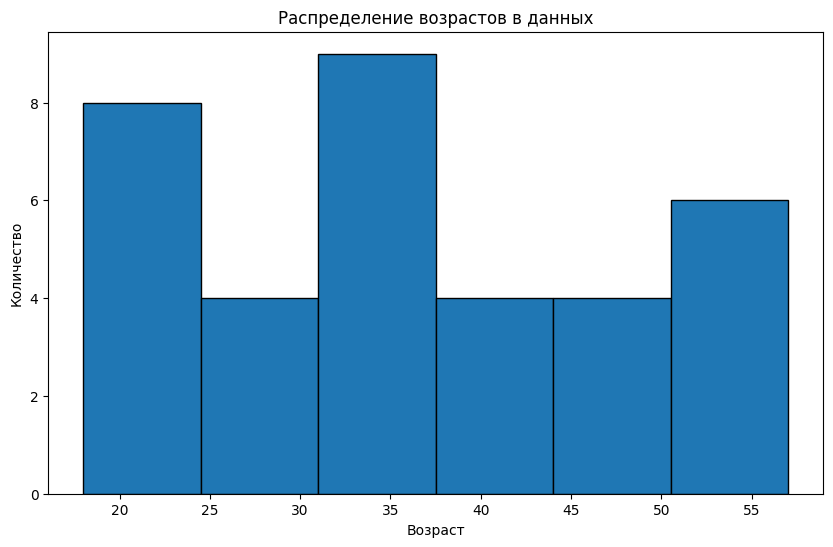

In [24]:
# Построим гистограмму дохода с опорой на правила Стёрджесса для выбора числа интервалов
n = 1 + int(np.log2(len(clean_data['age'])))

plt.figure(figsize=(10, 6))
plt.hist(clean_data['age'], edgecolor='black', bins=n)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возрастов в данных')
plt.show()

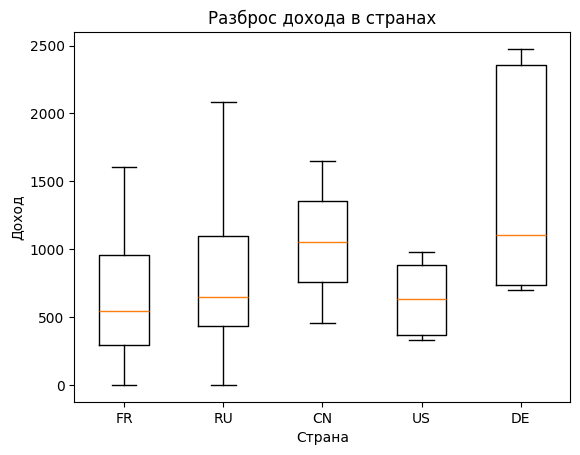

In [25]:
# Построим boxplot для дохода по странам

plt.boxplot([clean_data[clean_data['country']==country]['revenue'] for country in clean_data['country'].unique()])
plt.xticks(range(1,6), [country for country in clean_data['country'].unique()])
plt.xlabel('Страна')
plt.ylabel('Доход')
plt.title('Разброс дохода в странах')
plt.show()

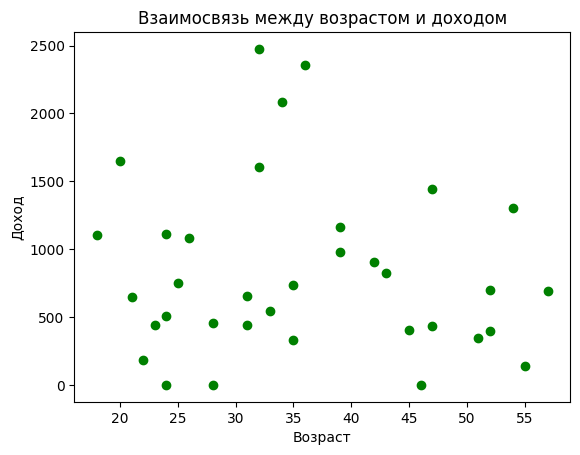

In [26]:
# Диаграмма рассеяния между возрастом и доходом

plt.scatter(clean_data['age'], clean_data['revenue'], color='green')
plt.xlabel('Возраст')
plt.ylabel('Доход')
plt.title('Взаимосвязь между возрастом и доходом')
plt.savefig('figures/age_revenue_scatter_plot.png')
plt.show()